In [1]:
import os
import pandas as pd
import numpy as np
import re
import pm4py

In [2]:
results_dir = "C:\\Users\\matte\\Desktop\\results\\"

real_results_dir = os.path.join(results_dir, "real")
real_classic_dir = os.path.join(real_results_dir, "classical_miners")
real_sommers_dir = os.path.join(real_results_dir, "sommers")

real_mine_dir = os.path.join(real_results_dir, "my_project")

all_miners_results = dict()

# Dataset analysis

In [3]:
%%capture
dataset_analysis = pd.DataFrame(columns=["dataset","no_variants","no_traces","mean_events_per_trace"])

dataset_dirs = os.listdir(real_mine_dir)

for ddir in dataset_dirs:
    logname = [file for file in os.listdir(os.path.join(real_mine_dir, ddir, "graphs", "logs")) if "xes" in file][0]
    log = pm4py.read_xes(os.path.join(real_mine_dir, ddir, "graphs", "logs", logname))
    no_variants = len(pm4py.get_variants_as_tuples(log))
    no_traces = len(log)
    no_events_list = []
    for trace in log:
        no_events_list = len(trace)
    mean_events_per_trace = np.mean(no_events_list)
    row = pd.DataFrame({"dataset":ddir,"no_variants":no_variants,"no_traces":no_traces,"mean_events_per_trace":mean_events_per_trace}, index=[0])
    dataset_analysis = pd.concat([dataset_analysis, row])

dataset_analysis.set_index("dataset", drop=True, inplace=True)

In [4]:
dataset_analysis.to_csv(os.path.join(real_results_dir,"real_analisys.csv"))

# Classic Miners

In [5]:
classical_dirs = os.listdir(real_classic_dir)

for cdir in classical_dirs:
    alpha_dir = os.path.join(real_classic_dir, cdir, "alpha")
    alpha_plus_dir = os.path.join(real_classic_dir, cdir, "alpha_plus")
    heuristics_dir = os.path.join(real_classic_dir, cdir, "heuristics")
    inductive_dir = os.path.join(real_classic_dir, cdir, "inductive")

    alpha_file = [file for file in os.listdir(alpha_dir) if "txt" in file][0]
    alpha_plus_file = [file for file in os.listdir(alpha_plus_dir) if "txt" in file][0]
    heuristics_file = [file for file in os.listdir(heuristics_dir) if "txt" in file][0]
    inductive_file = [file for file in os.listdir(inductive_dir) if "txt" in file][0]

    if cdir not in all_miners_results:
        all_miners_results[cdir] = dict()

    def parse_file_classical(filename, miner):
        if miner not in all_miners_results[cdir]:
            all_miners_results[cdir][miner] = dict()
        with open(filename, "r") as file:
            lines = file.readlines()
            for line in lines:
                if "fitness" in line:
                    result = re.findall(r"'log_fitness': \d\.\d+", line)
                    all_miners_results[cdir][miner]["fitness"] = float(result[0].split(':')[-1].replace(' ',''))
                elif "precision" in line:
                    result = re.findall(r"\d\.\d+", line)
                    all_miners_results[cdir][miner]["precision"] = float(result[0])
                elif "generalization" in line:
                    result = re.findall(r"\d\.\d+", line)
                    all_miners_results[cdir][miner]["generalization"] = float(result[0])
                elif "simplicity" in line:
                    result = re.findall(r"\d\.\d+", line)
                    all_miners_results[cdir][miner]["simplicity"] = float(result[0])

            fitness, precision = all_miners_results[cdir][miner]["fitness"], all_miners_results[cdir][miner]["precision"]
            all_miners_results[cdir][miner]["fscore"] = 2*fitness*precision/(fitness+precision)


    parse_file_classical(os.path.join(alpha_dir, alpha_file), "alpha")
    parse_file_classical(os.path.join(alpha_plus_dir, alpha_plus_file), "alpha_plus")
    parse_file_classical(os.path.join(heuristics_dir, heuristics_file), "heuristics")
    parse_file_classical(os.path.join(inductive_dir, inductive_file), "inductive")

# Sommers

In [6]:
sommers_dir = os.listdir(real_sommers_dir)

for sdir in sommers_dir:
    predictions_dir = os.path.join(real_sommers_dir, sdir, "predictions")
    predictions_file = os.path.join(predictions_dir, [file for file in os.listdir(predictions_dir) if "txt" in file][0])

    if "sommers" not in all_miners_results[sdir]:
            all_miners_results[sdir]["sommers"] = dict()

    def parse_file_sommers(filename):
        fitness = 0
        precision = 0
        generalization = 0
        simplicity = 0

        with open(filename, "r") as file:
            lines = file.readlines()
            for line in lines:
                if "fitness" in line:
                    result = re.findall(r"\d\.\d+", line)
                    fitness = max(float(result[0]), fitness)
                elif "precision" in line:
                    result = re.findall(r"\d\.\d+", line)
                    precision = max(float(result[0]),precision)
                elif "generalization" in line:
                    result = re.findall(r"\d\.\d+", line)
                    generalization = max(float(result[0]),generalization)
                elif "simplicity" in line:
                    result = re.findall(r"\d\.\d+", line)
                    simplicity = max(float(result[0]),simplicity)

            all_miners_results[sdir]["sommers"]["fitness"] = fitness
            all_miners_results[sdir]["sommers"]["precision"] = precision
            all_miners_results[sdir]["sommers"]["generalization"] = generalization
            all_miners_results[sdir]["sommers"]["simplicity"] = simplicity
            all_miners_results[sdir]["sommers"]["fscore"] = 2*fitness*precision/(fitness+precision)
    
    parse_file_sommers(predictions_file)

# Mine

In [7]:
my_dirs = os.listdir(real_mine_dir)

for mdir in my_dirs:
    no_silent_dir = os.path.join(real_mine_dir, mdir, "inference")
    silent_dir = os.path.join(real_mine_dir, mdir, "inference_silent")
    
    if "mine" not in all_miners_results[mdir]:
        all_miners_results[mdir]["mine"] = dict()
        
    if "mine_silent" not in all_miners_results[mdir]:
        all_miners_results[mdir]["mine_silent"] = dict()
        
    no_silent_file = os.path.join(no_silent_dir, [file for file in os.listdir(no_silent_dir) if "evaluation" in file][0])
    silent_file = os.path.join(silent_dir, [file for file in os.listdir(silent_dir) if "evaluation" in file][0])
    
    def parse_my_file(filename, miner):
        with open(filename, "r") as f:
            content = f.read()
            fitness_result = re.findall(r"\"log_fitness\": \d\.\d+", content)
            all_miners_results[mdir][miner]["fitness"] = float(fitness_result[0].split(':')[-1].replace(' ',''))
            precision_result = re.findall(r"\"precision\": \d\.\d+", content)
            all_miners_results[mdir][miner]["precision"] = float(precision_result[0].split(':')[-1].replace(' ',''))
            generalization_result = re.findall(r"\"generalization\": \d\.\d+", content)
            all_miners_results[mdir][miner]["generalization"] = float(generalization_result[0].split(':')[-1].replace(' ',''))
            simplicity_result = re.findall(r"\"simplicity\": \d\.\d+", content)
            all_miners_results[mdir][miner]["simplicity"] = float(simplicity_result[0].split(':')[-1].replace(' ',''))
            
            fitness = all_miners_results[mdir][miner]["fitness"]
            precision = all_miners_results[mdir][miner]["precision"]
            all_miners_results[mdir][miner]["fscore"] = 2*fitness*precision/(fitness+precision+1e-10)
    parse_my_file(no_silent_file, "mine")
    parse_my_file(silent_file, "mine_silent")

# Summary

In [8]:
final_dataframe = pd.DataFrame(columns=["dataset","miner","fscore","fitness","precision","generalization","simplicity"])

for dataset,miners in all_miners_results.items():
    for miner,metrics in miners.items():
        row = pd.DataFrame(
            {
                "dataset":dataset,
                "miner":miner,
                "fscore":metrics["fscore"],
                "fitness":metrics["fitness"],
                "precision":metrics["precision"],
                "generalization":metrics["generalization"],
                "simplicity":metrics["simplicity"]
            }, index=[0]
        )
        final_dataframe = pd.concat([final_dataframe, row])

final_dataframe = final_dataframe.set_index(["dataset", "miner"], drop=True)

## Save dataset

In [9]:
df_2012 = final_dataframe.loc["BPI_2012":"BPI_2012_W"]
df_2017 = final_dataframe.loc["BPI_2017":"BPI_2017_W"]
df_2020 = final_dataframe.loc["BPI_2020_Domestic_declarations":"BPI_2020_Request_for_payment"]
df_others = final_dataframe.loc["Hospital_Billing":"sepsis"]
    
df_2012.to_csv(os.path.join(real_results_dir,"df_2012.csv"))
df_2017.to_csv(os.path.join(real_results_dir,"df_2017.csv"))
df_2020.to_csv(os.path.join(real_results_dir,"df_2020.csv"))
df_others.to_csv(os.path.join(real_results_dir,"df_others.csv"))

## Graphs

In [10]:
import matplotlib.pyplot as plt

colors = ["pink","brown","red","green","cyan","blue","purple"]
miners = ["alpha", "alpha_plus", "heuristics", "inductive", "sommers", "mine", "mine_silent"]
labels = ["Alpha", "Alpha Plus", "Heuristics", "Inductive", "Sommers", "Ours", "Ours with silent transitions"]

### Precision v Fitness

#### 2012

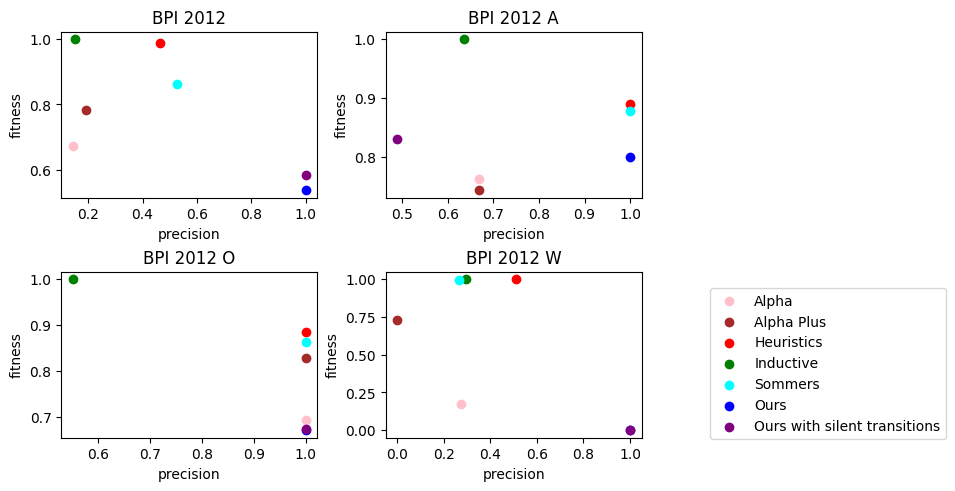

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012",miner]
    ax1.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fitness")
ax1.set_title("BPI 2012")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_A",miner]
    ax2.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fitness")
ax2.set_title("BPI 2012 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_O",miner]
    ax3.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fitness")
ax3.set_title("BPI 2012 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_W",miner]
    ax4.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fitness")
ax4.set_title("BPI 2012 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2017

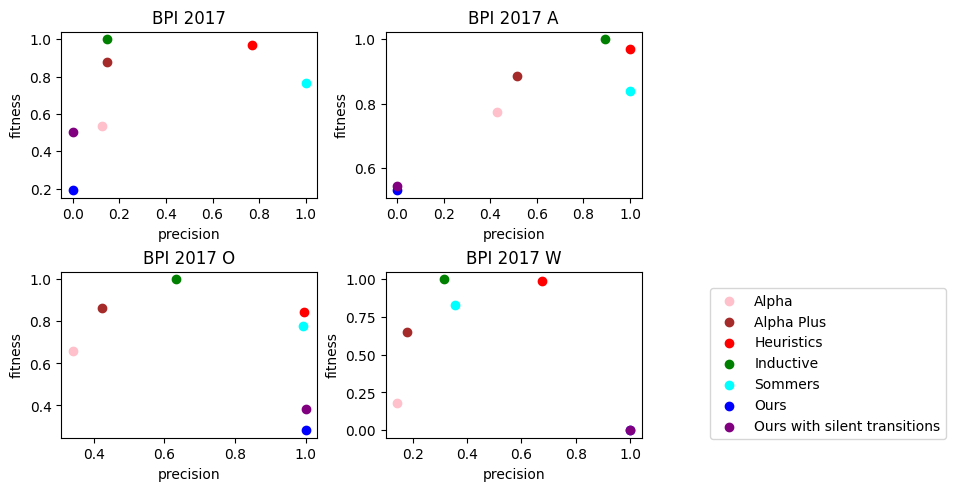

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017",miner]
    ax1.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fitness")
ax1.set_title("BPI 2017")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_A",miner]
    ax2.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fitness")
ax2.set_title("BPI 2017 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_O",miner]
    ax3.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fitness")
ax3.set_title("BPI 2017 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_W",miner]
    ax4.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fitness")
ax4.set_title("BPI 2017 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2020

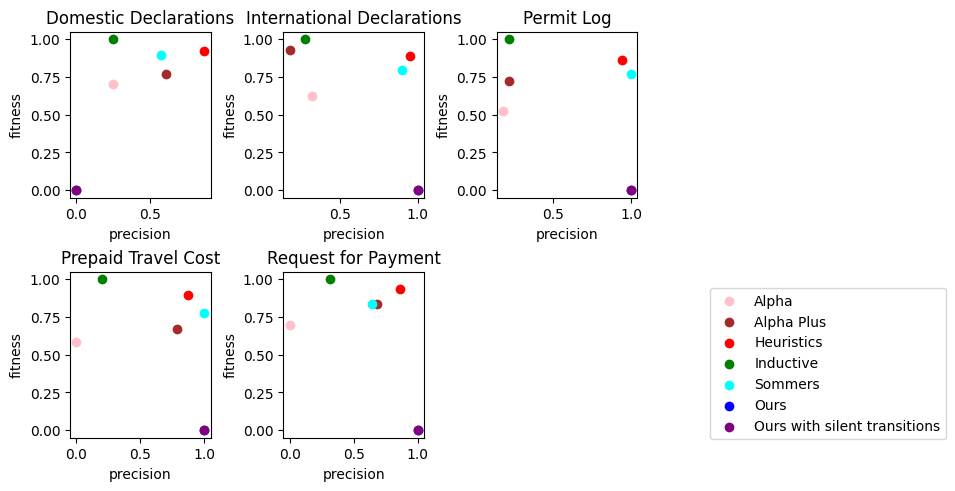

In [17]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout = True)
fig.delaxes(ax6)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Domestic_declarations",miner]
    ax1.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fitness")
ax1.set_title("Domestic Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_International_declarations",miner]
    ax2.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fitness")
ax2.set_title("International Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Permit_log",miner]
    ax3.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fitness")
ax3.set_title("Permit Log")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Prepaid_travel_cost",miner]
    ax4.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fitness")
ax4.set_title("Prepaid Travel Cost")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Request_for_payment",miner]
    ax5.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax5.set_xlabel("precision")
ax5.set_ylabel("fitness")
ax5.set_title("Request for Payment")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### Others

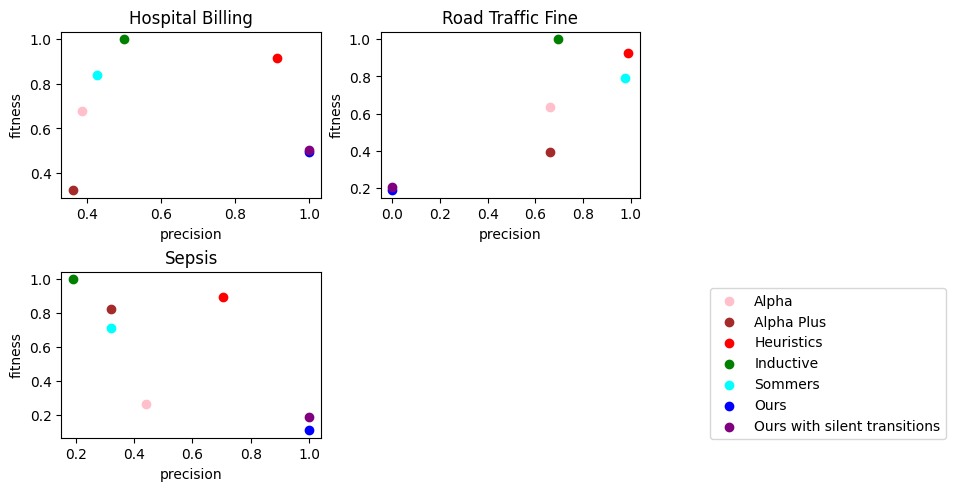

In [18]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, constrained_layout = True)
fig.delaxes(ax4)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["Hospital_Billing",miner]
    ax1.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fitness")
ax1.set_title("Hospital Billing")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["road_traffic_fine",miner]
    ax2.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fitness")
ax2.set_title("Road Traffic Fine")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["sepsis",miner]
    ax3.scatter(miner_results["precision"], miner_results["fitness"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fitness")
ax3.set_title("Sepsis")
  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

### Generalization v Similarity

#### 2012

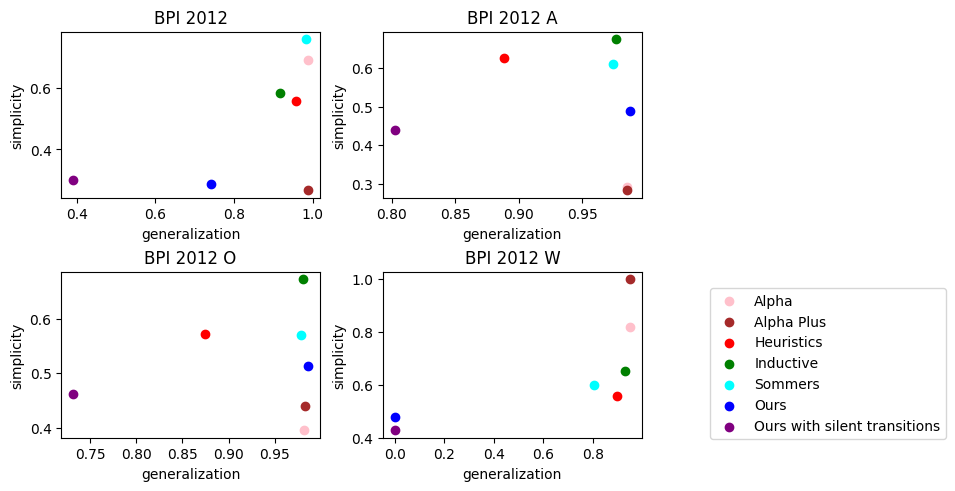

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012",miner]
    ax1.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("generalization")
ax1.set_ylabel("simplicity")
ax1.set_title("BPI 2012")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_A",miner]
    ax2.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("generalization")
ax2.set_ylabel("simplicity")
ax2.set_title("BPI 2012 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_O",miner]
    ax3.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("generalization")
ax3.set_ylabel("simplicity")
ax3.set_title("BPI 2012 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_W",miner]
    ax4.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("generalization")
ax4.set_ylabel("simplicity")
ax4.set_title("BPI 2012 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2017

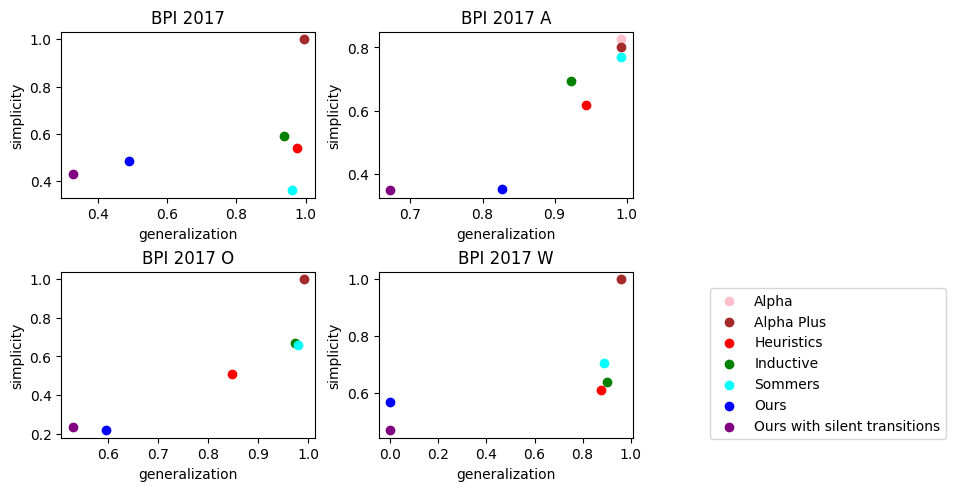

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017",miner]
    ax1.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("generalization")
ax1.set_ylabel("simplicity")
ax1.set_title("BPI 2017")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_A",miner]
    ax2.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("generalization")
ax2.set_ylabel("simplicity")
ax2.set_title("BPI 2017 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_O",miner]
    ax3.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("generalization")
ax3.set_ylabel("simplicity")
ax3.set_title("BPI 2017 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_W",miner]
    ax4.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("generalization")
ax4.set_ylabel("simplicity")
ax4.set_title("BPI 2017 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2020

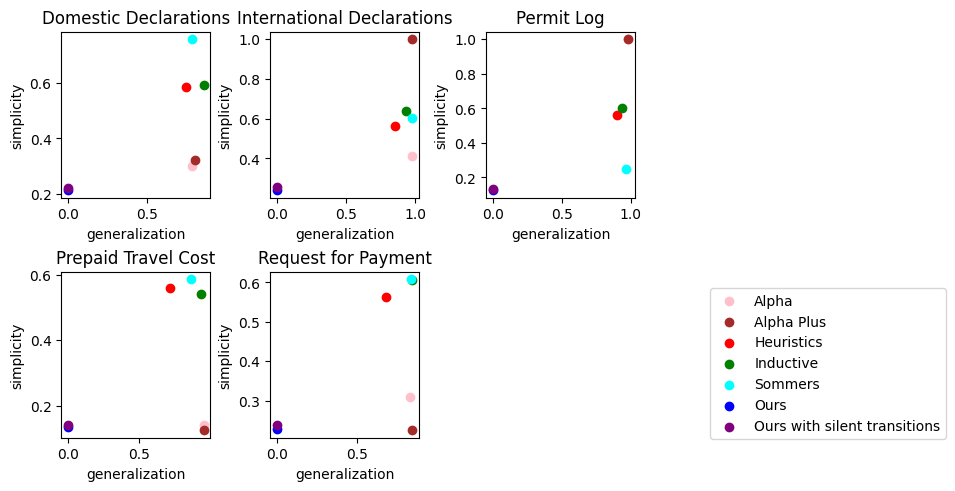

In [22]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout = True)
fig.delaxes(ax6)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Domestic_declarations",miner]
    ax1.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("generalization")
ax1.set_ylabel("simplicity")
ax1.set_title("Domestic Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_International_declarations",miner]
    ax2.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("generalization")
ax2.set_ylabel("simplicity")
ax2.set_title("International Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Permit_log",miner]
    ax3.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("generalization")
ax3.set_ylabel("simplicity")
ax3.set_title("Permit Log")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Prepaid_travel_cost",miner]
    ax4.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("generalization")
ax4.set_ylabel("simplicity")
ax4.set_title("Prepaid Travel Cost")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Request_for_payment",miner]
    ax5.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax5.set_xlabel("generalization")
ax5.set_ylabel("simplicity")
ax5.set_title("Request for Payment")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show() 

#### Others

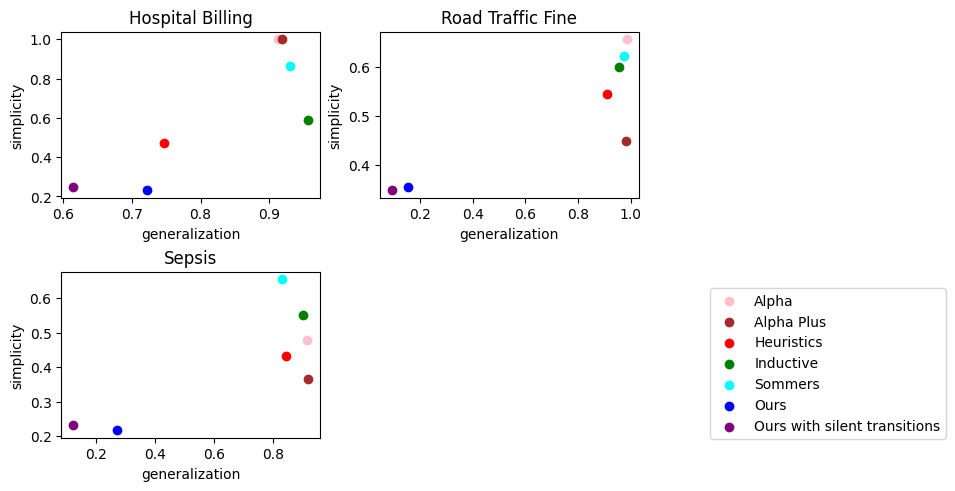

In [23]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, constrained_layout = True)
fig.delaxes(ax4)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["Hospital_Billing",miner]
    ax1.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("generalization")
ax1.set_ylabel("simplicity")
ax1.set_title("Hospital Billing")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["road_traffic_fine",miner]
    ax2.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("generalization")
ax2.set_ylabel("simplicity")
ax2.set_title("Road Traffic Fine")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["sepsis",miner]
    ax3.scatter(miner_results["generalization"], miner_results["simplicity"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("generalization")
ax3.set_ylabel("simplicity")
ax3.set_title("Sepsis")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

### Fitness v FScore

#### 2012

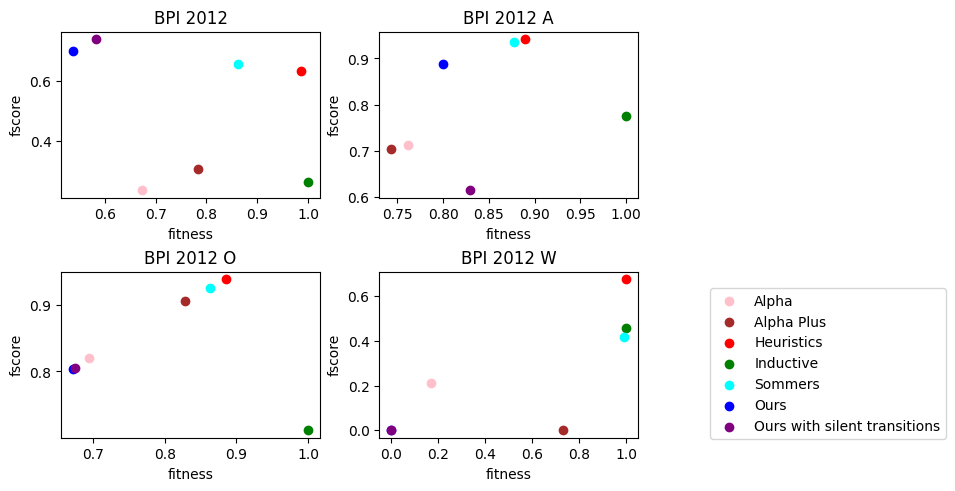

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012",miner]
    ax1.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("fitness")
ax1.set_ylabel("fscore")
ax1.set_title("BPI 2012")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_A",miner]
    ax2.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("fitness")
ax2.set_ylabel("fscore")
ax2.set_title("BPI 2012 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_O",miner]
    ax3.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("fitness")
ax3.set_ylabel("fscore")
ax3.set_title("BPI 2012 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_W",miner]
    ax4.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("fitness")
ax4.set_ylabel("fscore")
ax4.set_title("BPI 2012 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2017

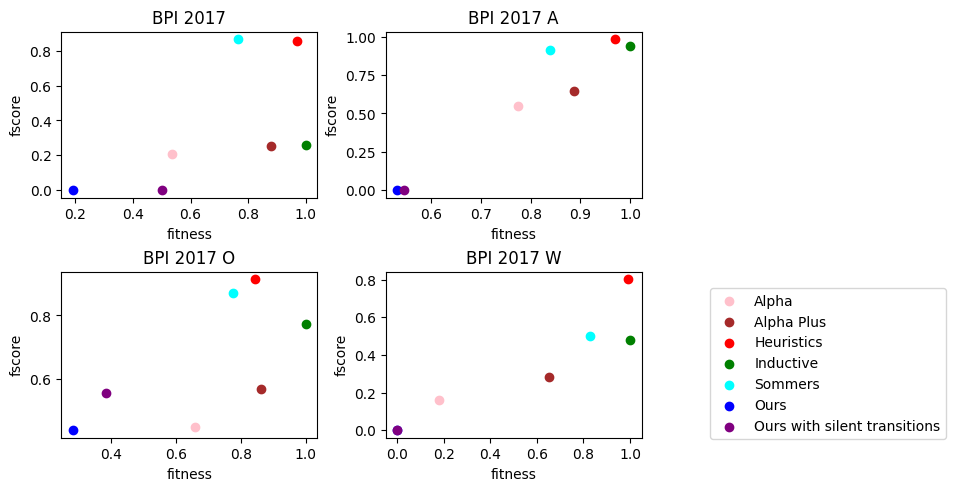

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017",miner]
    ax1.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("fitness")
ax1.set_ylabel("fscore")
ax1.set_title("BPI 2017")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_A",miner]
    ax2.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("fitness")
ax2.set_ylabel("fscore")
ax2.set_title("BPI 2017 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_O",miner]
    ax3.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("fitness")
ax3.set_ylabel("fscore")
ax3.set_title("BPI 2017 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_W",miner]
    ax4.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("fitness")
ax4.set_ylabel("fscore")
ax4.set_title("BPI 2017 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2020

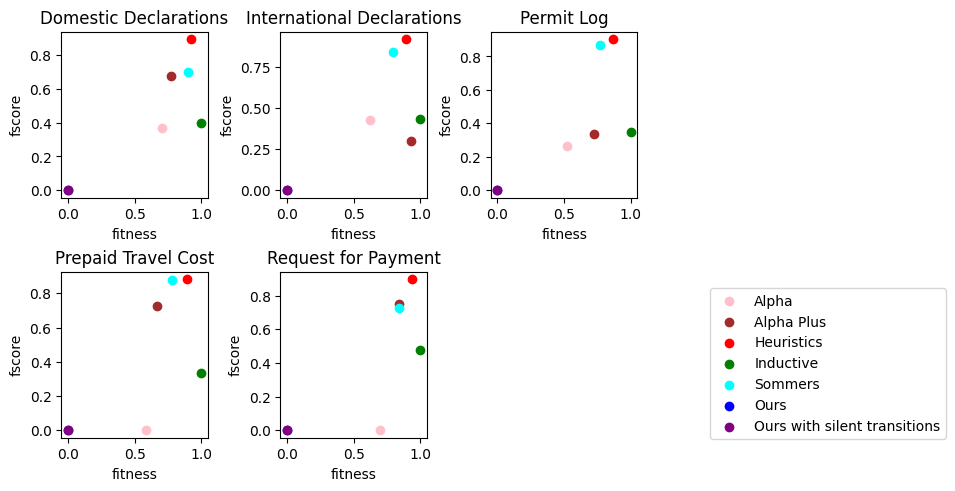

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout = True)
fig.delaxes(ax6)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Domestic_declarations",miner]
    ax1.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("fitness")
ax1.set_ylabel("fscore")
ax1.set_title("Domestic Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_International_declarations",miner]
    ax2.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("fitness")
ax2.set_ylabel("fscore")
ax2.set_title("International Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Permit_log",miner]
    ax3.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("fitness")
ax3.set_ylabel("fscore")
ax3.set_title("Permit Log")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Prepaid_travel_cost",miner]
    ax4.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("fitness")
ax4.set_ylabel("fscore")
ax4.set_title("Prepaid Travel Cost")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Request_for_payment",miner]
    ax5.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax5.set_xlabel("fitness")
ax5.set_ylabel("fscore")
ax5.set_title("Request for Payment")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### Others

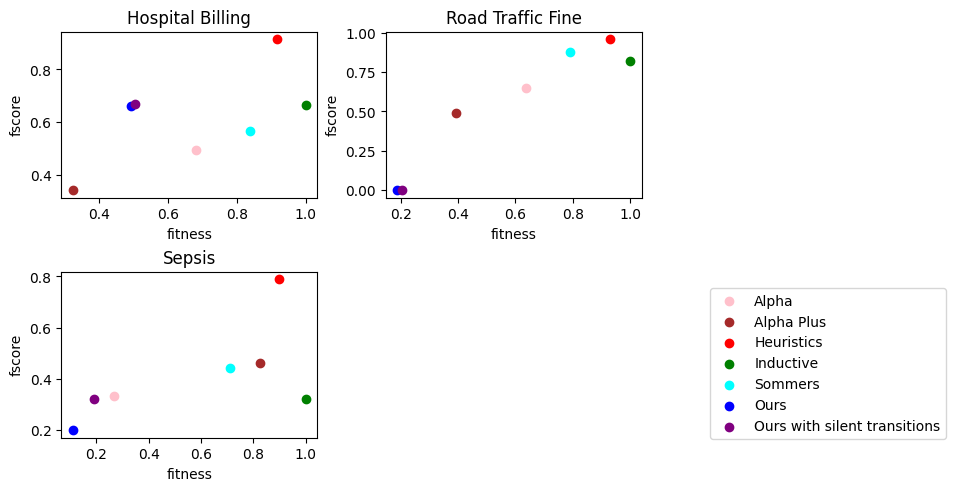

In [28]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, constrained_layout = True)
fig.delaxes(ax4)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["Hospital_Billing",miner]
    ax1.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("fitness")
ax1.set_ylabel("fscore")
ax1.set_title("Hospital Billing")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["road_traffic_fine",miner]
    ax2.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("fitness")
ax2.set_ylabel("fscore")
ax2.set_title("Road Traffic Fine")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["sepsis",miner]
    ax3.scatter(miner_results["fitness"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("fitness")
ax3.set_ylabel("fscore")
ax3.set_title("Sepsis")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

### Precision v Fscore

#### 2012

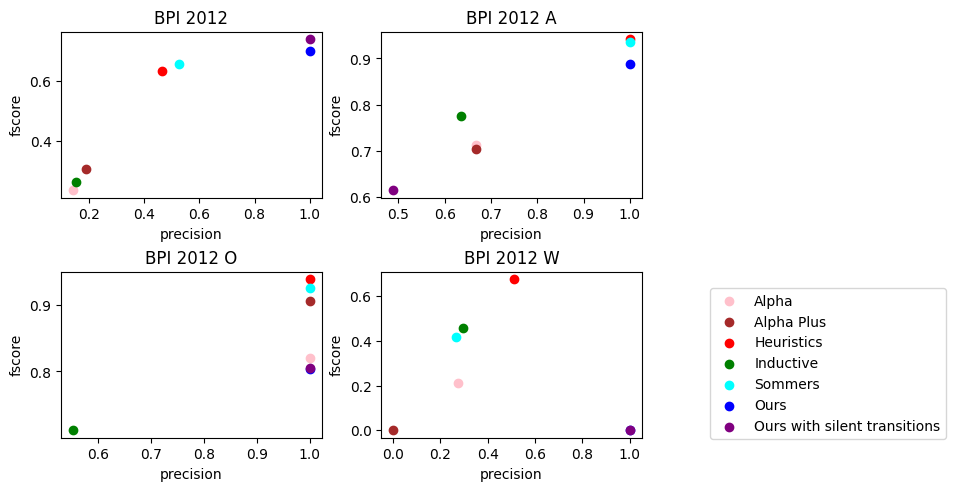

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012",miner]
    ax1.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fscore")
ax1.set_title("BPI 2012")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_A",miner]
    ax2.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fscore")
ax2.set_title("BPI 2012 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_O",miner]
    ax3.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fscore")
ax3.set_title("BPI 2012 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2012_W",miner]
    ax4.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fscore")
ax4.set_title("BPI 2012 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2017

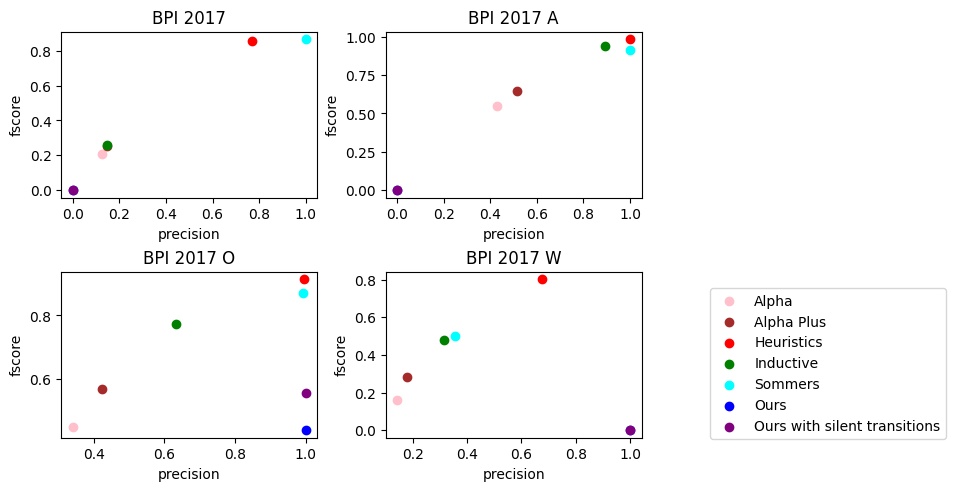

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017",miner]
    ax1.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fscore")
ax1.set_title("BPI 2017")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_A",miner]
    ax2.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fscore")
ax2.set_title("BPI 2017 A")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_O",miner]
    ax3.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fscore")
ax3.set_title("BPI 2017 O")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2017_W",miner]
    ax4.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fscore")
ax4.set_title("BPI 2017 W")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### 2020

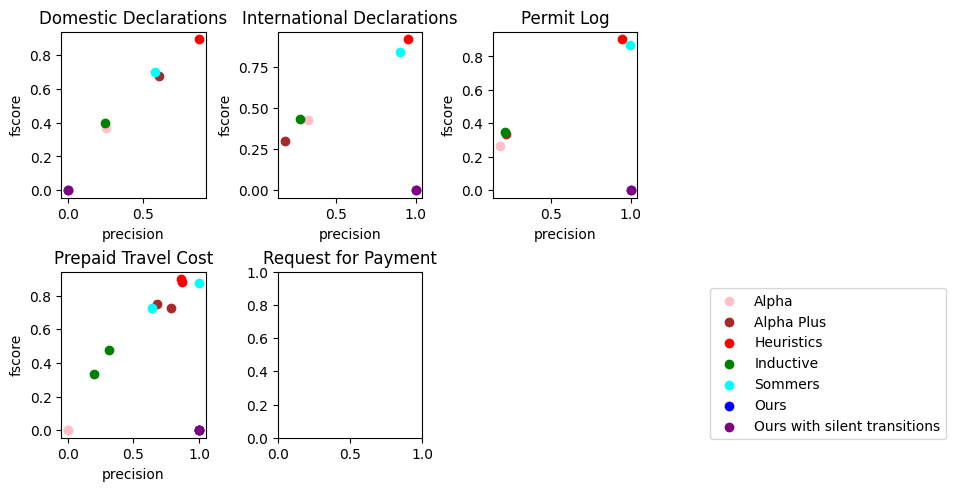

In [31]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout = True)
fig.delaxes(ax6)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Domestic_declarations",miner]
    ax1.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fscore")
ax1.set_title("Domestic Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_International_declarations",miner]
    ax2.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fscore")
ax2.set_title("International Declarations")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Permit_log",miner]
    ax3.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fscore")
ax3.set_title("Permit Log")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Prepaid_travel_cost",miner]
    ax4.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fscore")
ax4.set_title("Prepaid Travel Cost")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["BPI_2020_Request_for_payment",miner]
    ax4.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax4.set_xlabel("precision")
ax4.set_ylabel("fscore")
ax5.set_title("Request for Payment")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()

#### Others

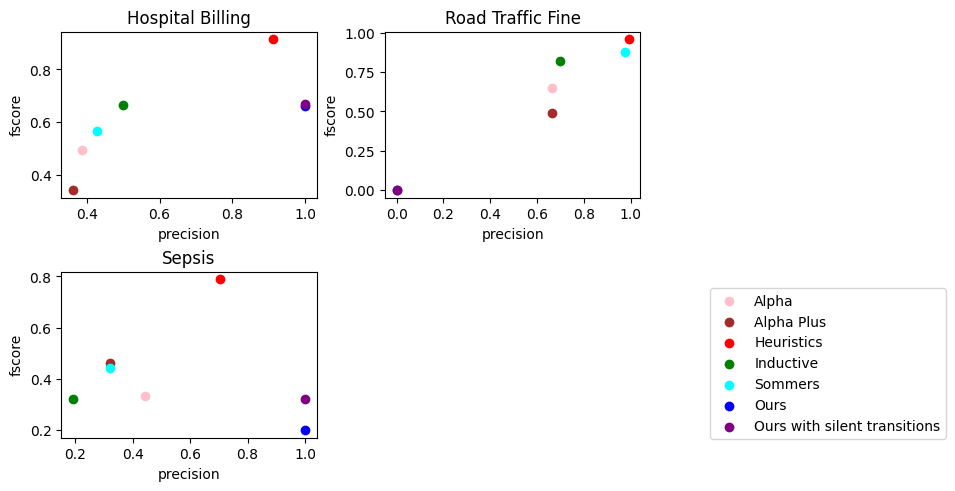

In [32]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, constrained_layout = True)
fig.delaxes(ax4)
for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["Hospital_Billing",miner]
    ax1.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax1.set_xlabel("precision")
ax1.set_ylabel("fscore")
ax1.set_title("Hospital Billing")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["road_traffic_fine",miner]
    ax2.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax2.set_xlabel("precision")
ax2.set_ylabel("fscore")
ax2.set_title("Road Traffic Fine")

for idx, miner in enumerate(miners):
    miner_results = final_dataframe.loc["sepsis",miner]
    ax3.scatter(miner_results["precision"], miner_results["fscore"], color=colors[idx], label=labels[idx])
ax3.set_xlabel("precision")
ax3.set_ylabel("fscore")
ax3.set_title("Sepsis")

  
fig.legend(labels, bbox_to_anchor=(1.1, 0.41), loc='upper left', borderaxespad=0)
plt.show()